# Figure 1

- Notebook to make figure one
- Moved from old on 2020.01.10
- by Cascade Tuholske

#### Dependencies

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import seaborn as sns
import glob

#### Functions

In [2]:
def make_pdays(df_stats, df_pop):
    
    "Makes a dataframe with stats and population to calc people days"
    
    # Make Population Long Format
    pop_long = pd.wide_to_long(df_pop, stubnames = 'P', i = 'ID_HDC_G0', j = 'year')
    pop_long.reset_index(level=0, inplace=True)
    pop_long.reset_index(level=0, inplace=True)
    pop_long = pop_long.drop('Unnamed: 0', axis = 1)
    
    # Get Total Days 
    data = df_stats.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
    pdays = pd.DataFrame()
    pdays['ID_HDC_G0'] = data['ID_HDC_G0']
    pdays['year'] = data['year']
    pdays['total_days'] = data['total_days']
    pdays['CTR_MN_NM'] = data['CTR_MN_NM']
    #pdays['sub-region'] = data['sub-region']
    #pdays['region'] = data['region']
    #pdays['intermediate-region'] = data['intermediate-region']
    
    # Merge
    pdays_merge = pdays.merge(pop_long, on=['ID_HDC_G0', 'year'], how = 'left')

    # Now get people days from 1983 and change
    p = pd.DataFrame()
    p['ID_HDC_G0'] = df_pop['ID_HDC_G0']
    p['P1983'] = df_pop['P1983']
    p['P2016'] = df_pop['P2016']
#    p['p_delt'] = (df_pop['P2016'] - df_pop['P1983']) / df_pop['P1983'] * 100

    pdays_merge = pdays_merge.merge(p ,on=['ID_HDC_G0'], how = 'left')
    
    # Calc p days = total days i * pop i 
    pdays_merge['people_days'] = pdays_merge['total_days'] * pdays_merge['P'] / 10**9 # total people days
    
    # Pdays due to heat increase = total days i - pop 83 - (total days 83 - pop 83) <<-- back out when graphing
    pdays_merge['people_days_heat'] = pdays_merge['total_days'] * pdays_merge['P1983'] / 10**9 # people days w/ pop con
    
    # Pdays due to pop increase = total days i * (pop i - pop 83)
    pdays_merge['people_days_pop'] = pdays_merge['total_days'] *(pdays_merge['P'] - pdays_merge['P1983']) /10**9 # dif

    return pdays_merge

In [3]:
def add_years(df):
    """ Function adds zero to people days for all missing years for each city 
    so that regressions aren't screwed up"""
    
    row_list = []
    counter = 0
    
    for city in list(np.unique(df['ID_HDC_G0'])):
        city_id = city
        city_df = df.loc[df['ID_HDC_G0'] == city]
        city_years = list(np.unique(city_df['year']))
        years = list(np.unique(df_data['year']))
        
        years_dif = list(set(years) - set(city_years))
        
        #print(len(years_dif))
        if len(years_dif) > 0:
            
            counter = counter + len(years_dif)
            
            for year in years_dif:
                row = []
                row.append(city) # city id
                row.append(year) # missing year
                row.append(0) # total days
                row.append(list(df[(df['ID_HDC_G0'] == city)]['CTR_MN_NM'])[0]) # country
                #row.append(list(df[(df['ID_HDC_G0'] == city)]['sub-region'])[0]) # sub-region
                #row.append(list(df[(df['ID_HDC_G0'] == city)]['region'])[0]) # region
                #row.append(list(df[(df['ID_HDC_G0'] == city)]['intermediate-region'])[0]) #intermediate-region
                row.append(float(df_pop[(df_pop['ID_HDC_G0'] == city)]['P'+str(year)])) # pop year
                row.append(float(df_pop[(df_pop['ID_HDC_G0'] == city)]['P'+str(1983)])) # pop 83
                row.append(float(df_pop[(df_pop['ID_HDC_G0'] == city)]['P'+str(2016)])) # pop 16
                row.append(0) # days
                row.append(0) # pdays 83
                row.append(0) # pdays diff
                
                row_list.append(row)
    
    df_new = pd.DataFrame(row_list, columns= df.columns)
    #print('new', len(df_new))
    #print('df', len(df))
    #print('sum', len(df)+len(df_new))
    
    df_new = df.append(df_new)
    #print('final', len(df))
    
    return df_new, counter

In [4]:
# Regressions, no intercept addition is needed because we're using SK LEARN HERE 

def lm_func(df, col, scale):
    
    "simple linear model of a time series data, returns coef"
    
    # Get Data
    X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df.groupby('year')[col].sum()).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit() 
        
    coef = int(model.params[1]*scale)
    #coef = int(coef)
            
    # R2 and P
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    return coef, round(r2, 2), round(p, 3)


# RAW HEAT PLOT

#### Open Files

In [5]:
# file paths
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"

# Raw Heat
FN_raw = 'processed/All_data_Raw406_es_final.csv'
raw_stats = pd.read_csv(DATA_IN+FN_raw)

# HI Heat
# FN_hi = 'processed/All_data_HI406.csv'
# hi_stats = pd.read_csv(DATA_IN+FN_hi)

FN_pop = 'interim/GHS-UCDB-Interp.csv'
df_pop = pd.read_csv(DATA_IN+FN_pop)

#### Make data

In [6]:
df_data = make_pdays(raw_stats, df_pop)

In [7]:
df_data.shape

(153517, 10)

In [8]:
df_data, counter = add_years(df_data)

In [9]:
counter 

85435

In [10]:
85435+153517

238952

In [11]:
df_data.shape

(238952, 10)

In [ ]:
#df_data.to_csv(DATA_IN+'processed/All_data_Raw406_es_final_pdayadd.csv')

Text(2.46, 0.8, '1192m increase in people-\ndays per year ($R^2$=0.66)*')

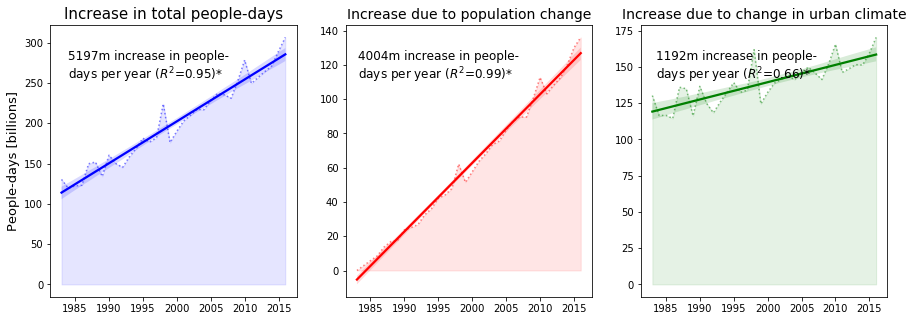

In [19]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharex=True)

## PLOT 1 - People Days
data = df_data.groupby('year')['people_days'].sum() 
years = list(data.index)
axs[0].plot(data, color = 'blue', linestyle = ':', alpha = 0.5)
axs[0].fill_between(years, data, color = 'blue', alpha = 0.1, label='_nolegend_')
sns.regplot(years, data, color = 'blue', ax = axs[0], scatter = False, truncate = True)
axs[0].set_title('Increase in total people-days', size = 15 )
axs[0].set_ylabel('People-days [billions]', fontsize = 13)

# Add text
coef, r2, p = lm_func(df_data, 'people_days', 10**3)
text = str(coef)+'m increase in people-\ndays per year ($R^2$=' + str(r2) + ')*'
axs[0].text(0.07, .8, text, transform=axs[0].transAxes, size=12)

#2 PLOT 2 - People Days delta pop x days
data = df_data.groupby('year')['people_days_pop'].sum() 
axs[1].plot(data, color = 'red', linestyle = ':', alpha = 0.5)
axs[1].fill_between(years, data, color = 'red', alpha = 0.1, label='_nolegend_')
sns.regplot(years, data, color = 'red', ax = axs[1], scatter = False, truncate = True)
axs[1].set_title('Increase due to population change', size = 14)
axs[1].set_ylabel('')

# Add text
coef, r2, p = lm_func(df_data, 'people_days_pop', 10**3)
text = str(coef)+'m increase in people-\ndays per year ($R^2$=' + str(r2) + ')*'
axs[1].text(1.25, .8, text, transform=axs[0].transAxes, size=12)

## PLOT 3 - People Days due to heat
data = df_data.groupby('year')['people_days_heat'].sum()
# pdays83 = data.get(data.index[0])
# data = data - pdays83
years = list(data.index)
axs[2].plot(data, color = 'green', linestyle = ':', alpha = 0.5)
axs[2].fill_between(years, data, color = 'green', alpha = 0.1, label='_nolegend_')
sns.regplot(years, data, color = 'green', ax = axs[2], scatter = False, truncate = True)
axs[2].set_title('Increase due to change in urban climate', size = 14)
axs[2].set_ylabel('')

# Add text
coef, r2, p = lm_func(df_data, 'people_days_heat', 10**3)
text = str(coef)+'m increase in people-\ndays per year ($R^2$=' + str(r2) + ')*'
axs[2].text(1.25*2-0.04, .8, text, transform=axs[0].transAxes, size=12,)

# Set y-axis
# for ax in fig.get_axes():
#     ax.label_outer()

# Title
# axs.set_title('Dayi * (Pi - P83)', fontsize = 20)
# axs.set_ylabel('Person Days [Billions]', fontsize = 20)
# axs.set_xlabel('Year', fontsize = 20)
# axs.tick_params(labelsize = 15)

#plt.savefig(FIG_OUT+'FIG1.png')

In [ ]:
coef_pd, r2, p = lm_func(df_data, 'people_days', 10**9)
coef_p, r2, p = lm_func(df_data, 'people_days_pop', 10**9)
coef_h, r2, p = lm_func(df_data, 'people_days_heat', 10**9)

In [ ]:
print(coef_pd)
print(coef_p + coef_h)

# HI HEAT PLOT

#### Open Files

In [13]:
# file paths
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"

# Raw Heat
FN_HI = 'processed/All_data_HI406.csv'
HI_stats = pd.read_csv(DATA_IN+FN_HI)

# HI Heat
# FN_hi = 'processed/All_data_HI406.csv'
# hi_stats = pd.read_csv(DATA_IN+FN_hi)

FN_pop = 'interim/GHS-UCDB-Interp.csv'
df_pop = pd.read_csv(DATA_IN+FN_pop)

#### Make data

In [14]:
df_data = make_pdays(HI_stats, df_pop)

In [15]:
df_data.shape

(346010, 10)

In [16]:
df_data, counter = add_years(df_data)

In [17]:
df_data.shape

(398514, 10)

In [ ]:
#df_data.to_csv(DATA_IN+'processed/All_data_Raw406_es_final_pdayadd.csv')

/home/cascade/miniconda3/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Text(0, 0.5, '')

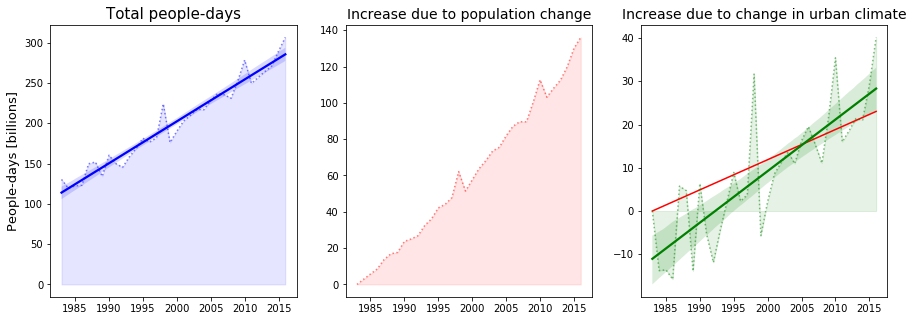

In [44]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharex=True)

## PLOT 1 - People Days
data = df_data.groupby('year')['people_days'].sum() 
years = list(data.index)
axs[0].plot(data, color = 'blue', linestyle = ':', alpha = 0.5)
axs[0].fill_between(years, data, color = 'blue', alpha = 0.1, label='_nolegend_')
sns.regplot(years, data, color = 'blue', ax = axs[0], scatter = False, truncate = True)
axs[0].set_title('Total people-days', size = 15 )
axs[0].set_ylabel('People-days [billions]', fontsize = 13)

# Add text
#coef, r2, p = lm_func(df_data, 'people_days', 10**3)
#text = str(coef)+'m increase in people-\ndays per year ($R^2$=' + str(r2) + ')*'
#axs[0].text(0.07, .8, text, transform=axs[0].transAxes, size=12)

#2 PLOT 2 - People Days delta pop x days
data = df_data.groupby('year')['people_days_pop'].sum() 
axs[1].plot(data, color = 'red', linestyle = ':', alpha = 0.5)
axs[1].fill_between(years, data, color = 'red', alpha = 0.1, label='_nolegend_')




#sns.regplot(years, data, color = 'red', ax = axs[1], scatter = False, truncate = True)
axs[1].set_title('Increase due to population change', size = 14)
axs[1].set_ylabel('')

# Add text
#coef, r2, p = lm_func(df_data, 'people_days_pop', 10**3)
#text = str(coef)+'m increase in people-\ndays per year ($R^2$=' + str(r2) + ')*'
#axs[1].text(1.25, .8, text, transform=axs[0].transAxes, size=12)

## PLOT 3 - People Days due to heat
data = df_data.groupby('year')['people_days_heat'].sum()
pdays83 = data.get(data.index[0])
data = data - pdays83

## ploy fit
x = np.array(years)-1983
y = np.array(data)
x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x, y)
axs[2].plot(x+1983, a*x, 'r-')

years = list(data.index)
axs[2].plot(data, color = 'green', linestyle = ':', alpha = 0.5)
axs[2].fill_between(years, data, color = 'green', alpha = 0.1, label='_nolegend_')
sns.regplot(years, data, color = 'green', ax = axs[2], scatter = False, truncate = True)
axs[2].set_title('Increase due to change in urban climate', size = 14)
axs[2].set_ylabel('')

# Add text
#coef, r2, p = lm_func(df_data, 'people_days_heat', 10**3)
#text = str(coef)+'m increase in people-\ndays per year ($R^2$=' + str(r2) + ')*'
#axs[2].text(1.25*2-0.04, .8, text, transform=axs[0].transAxes, size=12,)

# Set y-axis
# for ax in fig.get_axes():
#     ax.label_outer()

# Title
# axs.set_title('Dayi * (Pi - P83)', fontsize = 20)
# axs.set_ylabel('Person Days [Billions]', fontsize = 20)
# axs.set_xlabel('Year', fontsize = 20)
# axs.tick_params(labelsize = 15)

#plt.savefig(FIG_OUT+'FIG1.png')

In [ ]:
coef_pd, r2, p = lm_func(df_data, 'people_days', 10**9)
coef_p, r2, p = lm_func(df_data, 'people_days_pop', 10**9)
coef_h, r2, p = lm_func(df_data, 'people_days_heat', 10**9)

In [ ]:
print(coef_pd)
print(coef_p + coef_h)